# Compare Network Performance
Load in the results from the model trainings, and evaluate their performance

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from jcesr_ml.benchmark import load_benchmark_data
from sklearn.metrics import mean_absolute_error
from pathlib import Path
from tqdm import tqdm
from glob import glob
import pickle as pkl
import pandas as pd
import numpy as np
import json
import os

In /homes/lward/miniconda3/envs/solv_ml/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /homes/lward/miniconda3/envs/solv_ml/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /homes/lward/miniconda3/envs/solv_ml/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


## Load in the Test Data
We are going to use it to validate our models

In [2]:
_, test_data = load_benchmark_data()

In [3]:
baseline_water = (test_data['sol_water'] - test_data['sol_water'].mean()).abs().mean()
print(f'Baseline: {baseline_water:.2f}')

Baseline: 3.28


## Score All Models
Run all models on the test sets, store results in DataFrame

In [4]:
models = glob(os.path.join('networks', '**', 'test_results.csv'), recursive=True)

In [5]:
def score_model(path):
    """Given a log file, parse the settings for the network and the epoch time / ending val_loss
    
    Args:
        path (str): Get the path 
    """
    
    # Get the metadata from the `config.json` file
    path = Path(path)
    with open(path.parent / 'config.json') as fp:
        metadata = json.load(fp)
    metadata['path'] = path.parent
       
    # Score the model on the target variable
    with open(path.parent.parent / 'options.json') as fp:
        options = json.load(fp)
    output = options['output_props']
    metadata['output_variables'] = output
    
    # Load in the log
    log = pd.read_csv(path.parent / 'train_log.csv')
    metadata['epochs'] = len(log)
    metadata['median_epoch_time'] = np.percentile(log['epoch_time'], 50)
    metadata['total_time'] = log['epoch_time'].sum()
    metadata['best_loss'] = log['val_loss'].min()
    metadata['best_loss_epoch'] = log['val_loss'].idxmin()
    
    # Check whether the network had finished training
    metadata['finished'] = os.path.isfile(path.parent.joinpath('finished'))
    
    # Get the scores on the test set
    directory = path.parent
    test_data = pd.read_csv(path)
    pred_cols = [f'{x}_pred' for x in output]
    metadata['mae_all_outputs'] = mean_absolute_error(test_data[pred_cols], test_data[output])

    # Get the MAE on water only
    metadata['mae_water'] = mean_absolute_error(test_data['sol_water_pred'], test_data['sol_water'])
    return metadata

In [6]:
results = [score_model(x) for x in tqdm(models)]

100%|██████████| 64/64 [00:01<00:00, 46.24it/s]


In [7]:
results = pd.DataFrame(results)

In [8]:
results.to_csv('mpnn-results.csv', index=False)

## Evaluate the Models
Make sure that our models are working as expected

In [9]:
results.sort_values('mae_water', ascending=True)[['name', 'mae_water', 'finished', 'total_time',
                                                  'num_epochs', 'batch_size', 'median_epoch_time']].head(10)

,name,mae_water,finished,total_time,num_epochs,batch_size,median_epoch_time
56,dielectric-constant-softplus-charges,0.311397,False,16122.210022,1024,128,49.568679
55,dielectric-constant-softplus-charges_no-acn,0.311420,False,21166.209780,1024,128,48.870527
52,dielectric-constant-softplus-charges_no-acn,0.321039,False,14931.782964,512,128,49.467645
57,dielectric-constant-softplus-charges,0.326877,False,16441.457117,512,128,49.266604
53,dielectric-constant-softplus-charges_no-acn,0.339720,False,23127.664835,512,256,45.100256
58,dielectric-constant-softplus-charges,0.342348,False,18596.534805,512,256,45.165707
59,dielectric-constant-softplus-charges,0.342805,False,17837.363123,512,64,60.481515
54,dielectric-constant-softplus-charges_no-acn,0.377062,False,14446.542725,512,64,60.064262
1,dielectric-constant-softplus_no-acn,0.468302,False,17272.847854,1024,128,48.784879
6,single-task-atomic-contrib,0.468612,False,13731.897897,1024,128,49.921906


In [10]:
results.sort_values('mae_water', ascending=True).query('num_epochs==512')\
    [['name', 'mae_water', 'finished', 'total_time', 
      'epochs', 'batch_size', 'median_epoch_time']]

,name,mae_water,finished,total_time,epochs,batch_size,median_epoch_time
52,dielectric-constant-softplus-charges_no-acn,0.321039,False,14931.782964,302,128,49.467645
57,dielectric-constant-softplus-charges,0.326877,False,16441.457117,333,128,49.266604
53,dielectric-constant-softplus-charges_no-acn,0.339720,False,23127.664835,512,256,45.100256
58,dielectric-constant-softplus-charges,0.342348,False,18596.534805,412,256,45.165707
59,dielectric-constant-softplus-charges,0.342805,False,17837.363123,295,64,60.481515
54,dielectric-constant-softplus-charges_no-acn,0.377062,False,14446.542725,241,64,60.064262
4,single-task-atomic-contrib,0.472515,False,14578.816793,243,64,60.170968
45,dielectric-constant_no-acn,0.472570,False,29659.016668,512,64,57.596297
44,dielectric-constant_no-acn,0.477143,False,12957.373252,266,128,48.694846
20,dielectric-constant-softplus-mpnn-charges_no-acn,0.479680,False,13719.290727,278,128,49.354479


### Plot the Learning as Function of Epoch
Look for anomalous behavior

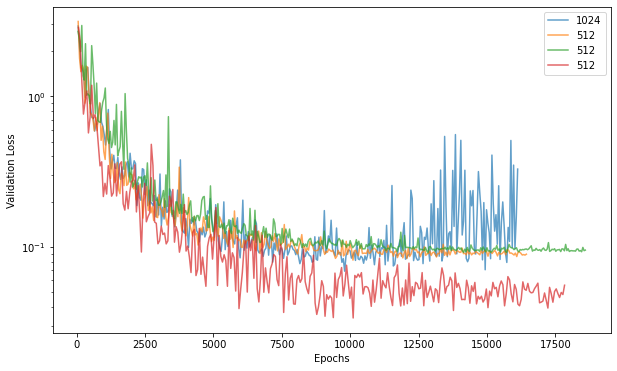

In [11]:
fig, ax = plt.subplots()

for _, f in results.query('name=="dielectric-constant-softplus-charges"').iterrows():
    log = pd.read_csv(os.path.join(f['path'], 'train_log.csv'))
    ax.semilogy(log['epoch_time'].cumsum(), log['val_loss'], label=f['num_epochs'], alpha=0.7)

ax.set_ylabel('Validation Loss')
ax.set_xlabel('Epochs')
ax.legend()
fig.set_size_inches(10, 6)

dielectric-constant-softplus_no-acn best loss after 200 epochs was at 72 epochs: 0.06354474276304245
dielectric-constant-softplus_no-acn best loss after 269 epochs was at 141 epochs: 0.21252357959747314
dielectric-constant-softplus_no-acn best loss after 499 epochs was at 371 epochs: 0.20678943395614624
single-task-atomic-contrib best loss after 243 epochs was at 115 epochs: 0.026606956496834755
single-task-atomic-contrib best loss after 405 epochs was at 277 epochs: 0.3707706332206726
single-task-atomic-contrib best loss after 282 epochs was at 154 epochs: 0.338492214679718
dielectric-constant best loss after 307 epochs was at 179 epochs: 0.22327378392219546
dielectric-constant best loss after 177 epochs was at 49 epochs: 0.120987631380558
dielectric-constant best loss after 294 epochs was at 166 epochs: 0.21358054876327515
dielectric-constant-softplus best loss after 512 epochs was at 454 epochs: 0.19524487853050232
dielectric-constant-softplus best loss after 512 epochs was at 474 e

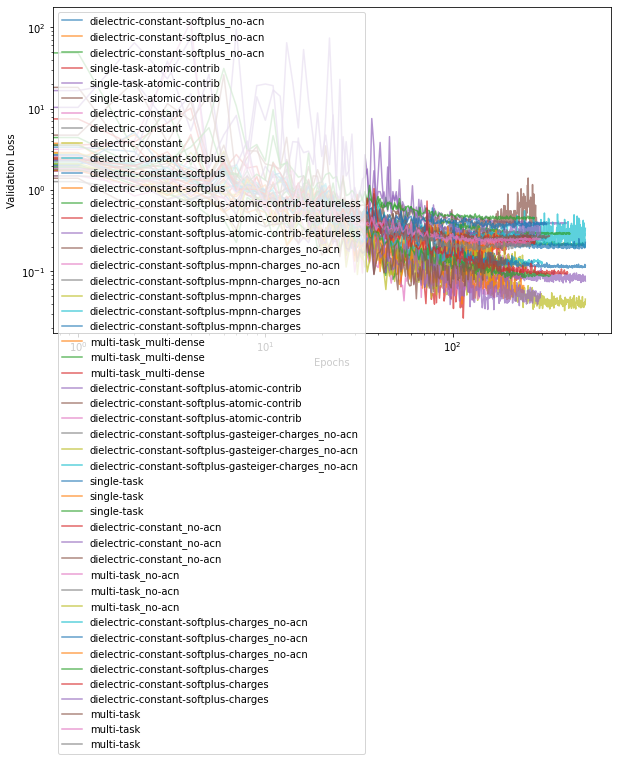

In [12]:
fig, ax = plt.subplots()

for _, f in results.query('num_epochs==512').iterrows():
    log = pd.read_csv(os.path.join(f['path'], 'train_log.csv'))
    print('{} best loss after {} epochs was at {} epochs:'.format(f['name'], len(log), log['val_loss'].idxmin() + 1),
              log['val_loss'].min())
    ax.loglog(log['epoch'], log['val_loss'], label=f['name'], alpha=0.7)

ax.set_ylabel('Validation Loss')
ax.set_xlabel('Epochs')
#ax.set_xlim(0, 2000)
ax.legend()
fig.set_size_inches(10, 6)